In this notebook, we prepare step by step the entraining plume. In short, we go through the following steps to compute the plume.

In [28]:
import numpy as np
import matplotlib.pyplot as plt

# Input from the user

In [90]:
# Input to the model
L_fire = 10000 # Length of the fire
d_fire = 300 # Depth of the fire
h0_fire = 20 # Height to start

C_fire = 17.781e6 # J / kg # Heat stored in fuel.
omega_fire = 7.6 # kg / m^2 # Fuel mass per area.
v_fire = 1.5 # m / s # Rate of spread of the fire.
radiative_loss_fire = 0.7 # fraction of F converted into radiative heating, and not into diffused into the atmosphere

In [91]:
# Constants
cp = 1005.0
Lv = 2.5e6
Rv = 461.5
Rd = 287.04
g = 9.81

# Set up the atmospheric profiles

In [92]:
# Assume we have a profile of theta and q on height coordinates, and the surface pressure
# L = 10000
# n = 128
# p0 = 101300.0

# dz = L / n
# z = np.arange(dz/2, L, dz)
# zh = np.arange(0, L+dz/2, dz)
# theta = 300 + 0.006 * z
# thetah = 300 + 0.006 * zh
# Hq = 2500
# qt = 0.005 * np.exp(-z/Hq)
# qth = 0.005 * np.exp(-zh/Hq)


In [93]:
# Set up the profiles following typical CLASS profiles.
dz = 20.0
p0 = 101300.0
z_top = 10000.0

h_in = 1000
theta_in = 300
dtheta_in = 2
gamma_theta_in = 0.006

qt_in = 0.005
dqt_in = -0.001
gamma_qt_in = -0.0001e-3

z = np.arange(h0_fire + dz/2, z_top, dz)
zh = np.arange(h0_fire, z_top+dz/2, dz)

theta = np.where(z < h_in, theta_in, theta_in + dtheta_in + gamma_theta_in * (z-h_in))
thetah = np.where(zh < h_in, theta_in, theta_in + dtheta_in + gamma_theta_in * (zh-h_in))

qt = np.where(z < h_in, qt_in, qt_in + dqt_in + gamma_qt_in * (z-h_in))
qth = np.where(zh < h_in, qt_in, qt_in + dqt_in + gamma_qt_in * (zh-h_in))

First, we assume that the environment is dry, and we compute the ambient pressure. We use the gas law for moist air.
$$
p = \rho R_\mathrm{d} \pi \theta_\mathrm{v}
$$
with $\pi = \left( \dfrac{p}{p_0} \right)^\frac{R_d}{c_p}$.

Then, we use hydrostatic balance and substitute the gas law:

$$
\begin{align}
\dfrac{\partial p}{\partial z}
&= -\rho g \\
&= -\dfrac{p g}{R_\mathrm{d} \pi \theta_\mathrm{v}} \\
\dfrac{\partial p^\frac{R_\mathrm{d}}{c_\mathrm{p}}}{\partial z}
&= -\dfrac{g}{c_\mathrm{p}}\dfrac{p_0^\frac{R_\mathrm{d}}{c_\mathrm{p}} }{\theta_\mathrm{v}} 
\end{align}
$$
with the latter equation, we can solve the pressure.

In [94]:
# We assume the base state is dry, so no saturation adjustment.
thetav = theta * (1 + (Rv/Rd - 1)*qt)
thetavh = thetah * (1 + (Rv/Rd - 1)*qth)

# Compute the pressure profile.
ph_Rdcp = np.zeros_like(zh)
ph_Rdcp[0] = p0**(Rd/cp)
for i in range(1, len(ph_Rdcp)):
    ph_Rdcp[i] = ph_Rdcp[i-1] - g/cp * p0**(Rd/cp) / thetav[i-1] * dz

ph = ph_Rdcp**(cp/Rd)
p = np.exp(0.5*(np.log(ph[:-1]) + np.log(ph[1:])))

exner = (p/p0)**(Rd/cp)
exnerh = (ph/p0)**(Rd/cp)

T = exner*theta
Th = exnerh*thetah

rho = p / (Rd * exner * thetav)
rhoh = ph / (Rd * exnerh * thetavh)

Text(0.5, 0, 'T')

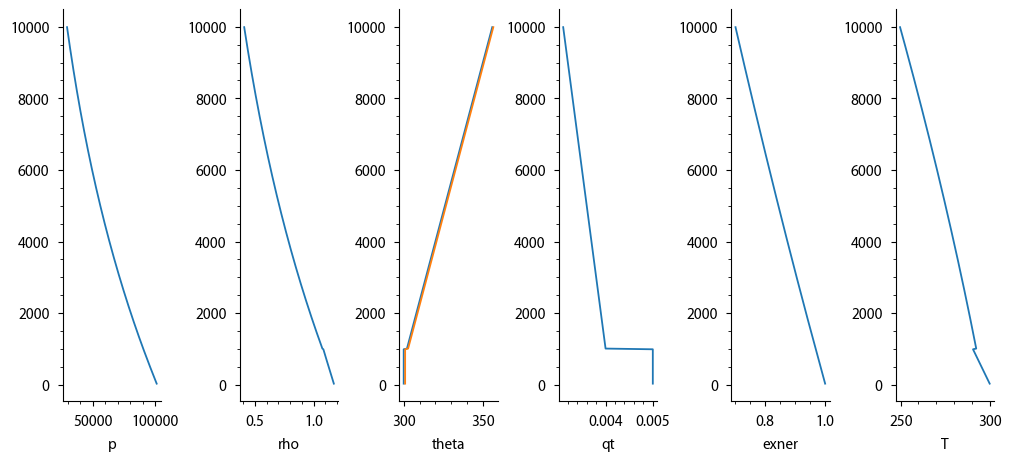

In [95]:
plt.figure(figsize=(10, 4.5), constrained_layout=True)
plt.subplot(161)
plt.plot(p, z)
plt.xlabel("p")
plt.subplot(162)
plt.plot(rho, z)
plt.xlabel("rho")
plt.subplot(163)
plt.plot(theta, z)
plt.plot(thetav, z)
plt.xlabel("theta")
plt.subplot(164)
plt.plot(qt, z)
plt.xlabel("qt")
plt.subplot(165)
plt.plot(exner, z)
plt.xlabel("exner")
plt.subplot(166)
plt.plot(T, z)
plt.xlabel("T")

# Calculate the plume ascent

In [96]:
area_fire = L_fire * d_fire
F_fire = omega_fire * C_fire * v_fire / d_fire * (1 - radiative_loss_fire)
F_q_fire = 0. * F_fire # Dry plume for now

w_bot = (3 * g * F_fire * h0_fire / (2 * rho[0] * cp * thetav[0]))**(1./3)
dtheta = F_fire / (rho[0] * cp * w_bot)
dqv = F_q_fire / (rho[0] * Lv * w_bot)

print(F_fire, dtheta, dqv, w_bot, area_fire)

202703.40000000002 31.171850881654454 0.0 5.521497754994179 3000000


In [97]:
# Define excess temperature and humidity and fire size (this is for testing to override the surface model)
# dtheta = 10
# dqv = 0.001
# w_bot = 1

In [98]:
# First, set the near-surface plume conditions
theta_plume = theta.copy()
qt_plume = qt.copy()

b_plume = np.zeros_like(theta)
area_plume = np.zeros_like(theta)
m_plume = np.zeros_like(theta)
w_plume = np.zeros_like(theta)
e_plume = np.zeros_like(theta)
d_plume = np.zeros_like(theta)

theta_plume[0] += dtheta
qt_plume[0] += dqv
dthetav_bot = theta_plume[0] * (1 + (Rv/Rd - 1)*qt_plume[0]) - thetav[0]
b_plume[0] = g/thetav[0] * dthetav_bot
area_plume[0] = area_fire
w_plume[0] = w_bot
m_plume[0] = rho[0] * area_plume[0] * w_plume[0]
e_plume[0] = rho[0] * area_plume[0] / (2*w_plume[0]) * b_plume[0]

print(b_plume[0], area_plume[0], w_plume[0], e_plume[0], d_plume[0], m_plume[0])

1.0193195238300998 3000000.0 5.521497754994179 324504.0963215716 0.0 19411255.95706969


In [88]:
# Loop through the profile
for i in range(1, len(z)):
    # Mass flux through plume
    m_plume[i] = m_plume[i-1] + (e_plume[i-1] - d_plume[i-1]) * dz
    
    # Apply the mass flux to the conserved variables
    theta_plume[i] = theta_plume[i-1] - e_plume[i-1] * (theta_plume[i-1] - theta[i-1]) / m_plume[i-1] * dz
    qt_plume[i] = qt_plume[i-1] - e_plume[i-1] * (qt_plume[i-1] - qt[i-1]) / m_plume[i-1] * dz

    b_plume[i] = g/thetav[i] * (theta_plume[i] * (1 + (Rv/Rd - 1)*qt_plume[i]) - thetav[i])

    # Solve the vertical velocity
    a_w = 1
    b_w = 0
    w_plume[i] = w_plume[i-1] + (-b_w * e_plume[i-1] * w_plume[i-1] + a_w * area_plume[i-1] * rho[i-1] * b_plume[i-1]) / m_plume[i-1] * dz

    z_sl = 100.0
    crossed_sl = False
    lambda_mix = 30 # Mixing length in surface layer.
    beta = 1 # Fractional detrainment above surface layer.
    
    if z[i] < z_sl:
        # Entrainment and detrainment in the surface layer.
        e_plume[i] = area_plume[i-1] * rho[i-1] / (2 * w_plume[i-1]) * b_plume[i-1]
        d_plume[i] = area_plume[i-1] * rho[i-1] * np.sqrt(lambda_mix) / np.sqrt(area_plume[0]) * (
            np.sqrt(z[i]) * (w_plume[i] - w_plume[i-1]) / dz + w_plume[i-1] / (2 * np.sqrt(z[i]))
        )

    else:
        # Entrainment and detrainment above the surface layer.
        if not crossed_sl:
            epsi = e_plume[i-1] / m_plume[i-1] # This is different than in Martin's version, I read the prev level.
            delt = epsi / beta # Delta is discontinous 
            # delt = d_plume[i-1] / m_plume[i-1]
            crossed_sl = True
    
        e_plume[i] = epsi * m_plume[i]
        d_plume[i] = delt * m_plume[i]

    area_plume[i] = m_plume[i] / (rho[i] * w_plume[i])

    if w_plume[i] < 0 or area_plume[i] < 0:
        area_plume[i] = np.nan
        break

/var/folders/4f/nykt4nhx4kn12sz633_msth40000gn/T/ipykernel_76578/4109084367.py:11: RuntimeWarning: invalid value encountered in divide
  plt.plot(e_plume / m_plume, z)
/var/folders/4f/nykt4nhx4kn12sz633_msth40000gn/T/ipykernel_76578/4109084367.py:12: RuntimeWarning: invalid value encountered in divide
  plt.plot(d_plume / m_plume, z)


Text(0.5, 0, 'mass flux')

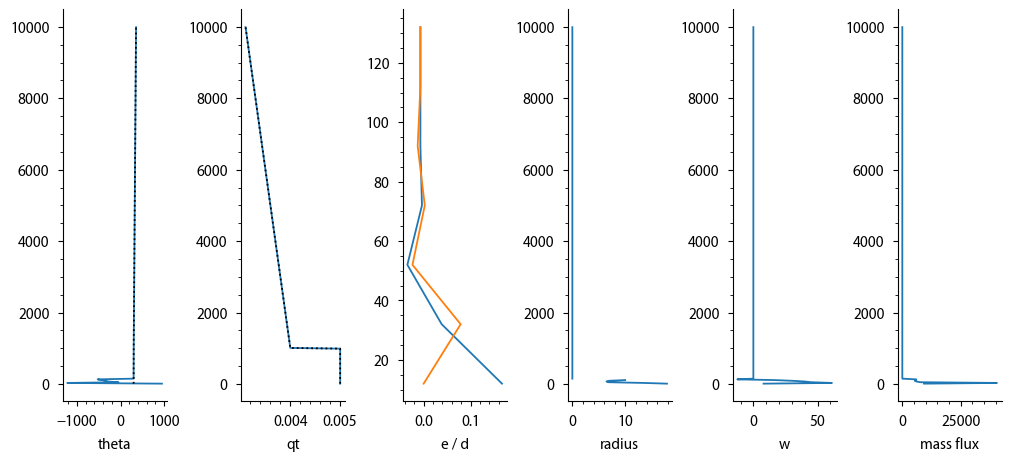

In [89]:
plt.figure(figsize=(10, 4.5), constrained_layout=True)
plt.subplot(161)
plt.plot(theta_plume, z)
plt.plot(theta, z, 'k:')
plt.xlabel('theta')
plt.subplot(162)
plt.plot(qt_plume, z)
plt.plot(qt, z, 'k:')
plt.xlabel('qt')
plt.subplot(163)
plt.plot(e_plume / m_plume, z)
plt.plot(d_plume / m_plume, z)
plt.xlabel('e / d')
plt.subplot(164)
plt.plot((area_plume/np.pi)**.5, z)
plt.xlabel('radius')
plt.subplot(165)
plt.plot(w_plume, z)
plt.xlabel('w')
plt.subplot(166)
plt.plot(m_plume, z)
plt.xlabel('mass flux')